# Kernel Sparse Semisupervised Heterogeneous Interbaterry Bayessian Analysis (KSSHIBA)
Author: _(Updated: 13/05/2020)_

In this notebook we are going to review the method proposed in [Bayesian Sparse Factor Analysis with Kernelized Observations](https://arxiv.org/pdf/2006.00968.pdf) and show the different available functionalities of KSSHIBA:
1. A model capable of working with **kernelized observations**, being able to explote non-linear relationshipgs with a bayesian linear model.
2. **Semisupervised** model which infers missing data as well as the data we want to predict.
3.  **Feature Selection** capabilities by including sparsity over the data features/characteristics as the model is trained.
4.  A **Support Vector Selection** approach to determine the relevance of each observation in the kernel representation.
5.  **Heterogeneous** views to broaden the problems the model can work with.

As the model is able to work in different scenarios, we will try to cover them in the notebook, including some synthetic data to visualize the results. Nevertheless, the strength of the model is that it has been adpated to work with any combination of the previous modifications, i.e. kernel Semisupervised, sparse, multilabel and multiview at the same time.

# Working with kernelized observations

This algorithm looks for linear projections of the observable data in a latent space by finding correlation between the data. In particular, we have a random variable in the latent space, $Z$, which when combined with the projection matrices, $A^{(m)}$, and adding some noise, $\Sigma^{(m)}$, is capable of modelling the kernelized data $K^{(m)}$. By including this kernel matrix $K^{(m)}$ we can also include non-linearities in the generative model. To impose sparsity in the latent space, the projection matrices $A^{(m)}$ are combined with the random variable $\alpha^{(m)}$ and the noise, $\Sigma^{(m)}$, is modelled with $\tau^{(m)}$. Here we present the proposed graphical model
<img src="http://www.tsc.uc3m.es/~sevisal/Graphic_Model.png" style="max-width:100%; width: 70%">

This scheme introduces the different variables that compose the algorithm as well as the relation between them. The distribution of these variables are defined in the following equations:

<img src="http://www.tsc.uc3m.es/~sevisal/Distributions.png" style="max-width:100%; width: 40%">

Having the generative model, using mean field approximation to calculate the posterior distribution of the model, the variational inference provides an approximate distribution for each random variable, as seen in the article. Once the model is trained, the predictive model can be used to obtain a prediction of the targets or labels.

## Synthetic linear data generation

We can generate synthetic data to test the performance of the model following the variable distributions of standar version (linear) of SSHIBA in order to be able to compare it with its kernel counterpart.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from sklearn.metrics import r2_score
np.random.seed(0)

N = 100  # number of samples
D0 = 5000  # input features
D1 = 3   # output features

K = 2       # common latent variables
K0 = 3      # first view's latent variables
K1 = 3      # second view's latent variables
Kc = K+K0+K1  # latent variables

# Generation of matrix W
A0 = np.random.normal(0.0, 1, D0 * K).reshape(D0, K)
A1 = np.random.normal(0.0, 1, D1 * K).reshape(D1, K)

B0 = np.random.normal(0.0, 1, D0 * K0).reshape(D0, K0)
B1 = np.random.normal(0.0, 1, D1 * K1).reshape(D1, K1)

W0 = np.hstack((np.hstack((A0,B0)),np.zeros((D0,K1))))
W1 = np.hstack((np.hstack((A1,np.zeros((D1,K0)))),B1))

# Generation of matrix Z
Z = np.random.normal(0.0, 1, Kc * N).reshape(N, Kc)

# Generation of matrix X
X00 = np.dot(Z,W0.T) + np.random.normal(0.0, 0.1, D0 * N).reshape(N, D0)
X1 = np.dot(Z,W1.T) + np.random.normal(0.0, 0.1, D1 * N).reshape(N, D1)

from sklearn.model_selection import train_test_split
# split into a training and testing set
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X00, X1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)
X = np.vstack((X_tr, X_tst))

Once the data is generated we divide it into train and test in order to be able to test the performance of the model. After that, we can normalize the data.

### Training the models

Once the data is prepared we just have to feed it to the model. As the model has so many possibilities we have decided to pass the data to the model following a particular structure so that we can now, for each view, specify if the data corresponds to real, multilabel or categorical as well as knowing if we want to calculate the model with sparsity in the features.

In [0]:
import os
os.sys.path.append('lib')
import ksshiba

In this case, we are training the SSHIBA model using the original data X as an input. We calculate it in the semsupervised version of the model.

Note that both SSHIBA and KSSHIBA are included in the same library. The library works with one or the other depending on whether you specify a support vector matrix ($V$) in the input struct or not.

In [0]:
myKc = 20            # number of latent features
prune = 1            # whether or not to prune the latent factors

# Training SSHIBA, in the primal space
myModel = ksshiba.SSHIBA(myKc, prune)   
Y1_tr = myModel.struct_data(Y_tr, 'reg', 0)
Y1_tst = myModel.struct_data(Y_tst, 'reg', 0)
X0 = myModel.struct_data(X, 'reg', 0)
tic = time()
myModel.fit(X0, Y1_tr, verbose = 1)
Y_pred = myModel.compute_predictions(X_tst = [None], m_in=[0], m_out=1, tr=0)
print('R2 SSHIBA: %.3f' %(r2_score(Y_tst, Y_pred, multioutput = 'uniform_average')))
print('Time SSHIBA: %.1f s' %(time()-tic))

Iteration 1000 Lower Bound 2590839.1 K   20
R2 SSHIBA: 0.267
Time SSHIBA: 1147.6 s


Now, let's use the same data to train the model, but now in the dual space, having that the input for the KSSHIBA is the linear kernel of the original data (i.e, we reconstruct linear kernelized observations).

In [0]:
myKc = 20            # number of latent features
prune = 1            # whether or not to prune the latent factors

# Training KSSHIBA, in the dual space
myKModel = ksshiba.SSHIBA(myKc, prune)   
Y1_tr = myKModel.struct_data(Y_tr, 'reg', 0)
Y1_tst = myKModel.struct_data(Y_tst, 'reg', 0)
K0 = myKModel.struct_data(X, 'reg', 0, V = X, kernel = 'linear')

tic = time()
myKModel.fit(K0, Y1_tr, verbose = 1)
Y_pred = myKModel.compute_predictions(X_tst = [None], m_in=[0], m_out=1)
print('R2 KSSHIBA: %.3f' %(r2_score(Y_tst, Y_pred, multioutput = 'uniform_average')))
print('Time KSSHIBA: %.1f s' %(time()-tic))

Working on the dual space.
Iteration 941 Lower Bound 26815.4 K   16
Model correctly trained. Convergence achieved
R2 KSSHIBA: 0.413
Time KSSHIBA: 6.9 s


We can see that not only the performance is improved, the number of latent factors is lower than for SSHIBA. Furthermore by working in the dual space, the model is trained in considerably less time.

### Visualization of the results

In this section we are going to analyse the model we have trained and corroborate the assumptions and conditions we set when proposing the method.

#### Kernel reconstruction

When proposing the kernel version of SSHIBA following the previous set distributions we are considering that the data distribution was independent. However, being a kernel we know the rows and columns of the input data are not independent. Nevertheless, parting from this assumption we can train the model and check how the generative model learns the kernel representation.

In this case we are calculating the mean of the distribution of the input data, given by $\mu_{K^{(0)}} = Z  W^{(0)^T}$, where 0 corresponds to the input view, and comparing it to the original kernel matrix, $K^{(0)}$.

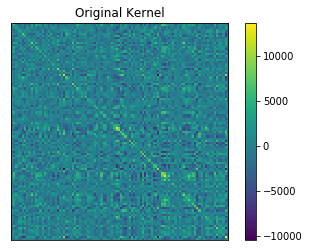

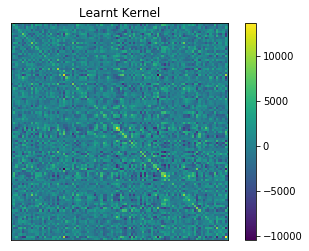

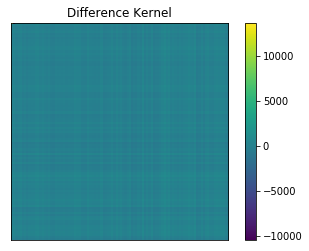

In [0]:
def plot_K(K, title):
    plt.figure()
    plt.imshow((K))
    plt.colorbar()
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    plt.show()

K = np.dot(X, X.T)
mean_K = np.dot(myKModel.q_dist.Z['mean'], myKModel.q_dist.W[0]['mean'].T)
diff_K = K - mean_K
mx = np.max(np.vstack((K, mean_K, diff_K)))
mn = np.min(np.vstack((K, mean_K, diff_K)))
K[0,0] = mx
K[0,1] = mn
mean_K[0,0] = mx
mean_K[0,1] = mn
diff_K[0,0] = mx
diff_K[0,1] = mn

plot_K(K, 'Original Kernel')
plot_K(mean_K, 'Learnt Kernel')
plot_K(diff_K, 'Difference Kernel')

## Synthetic non linear data generation

We can now test another advantage of being able to work with kernelized observations. Here we want to compare the extracted features and performance of the model in its primal formulation and its dual formulation, using a non-linear kernel.

Therefore, we start by generating some random non-linear observations.

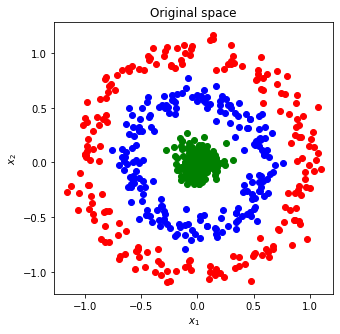

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

np.random.seed(0)
X, Y = make_circles(n_samples=400, factor=.6, noise=.08)

X_c2 = 0.1*np.random.randn(200,2)
Y_c2 = 2*np.ones((200,))

X = np.vstack([X,X_c2])
Y = np.hstack([Y,Y_c2])

plt.figure(figsize=(5, 5))
plt.title("Original space")
reds = Y == 0
blues = Y == 1
green = Y == 2

plt.plot(X[reds, 0], X[reds, 1], "ro")
plt.plot(X[blues, 0], X[blues, 1], "bo")
plt.plot(X[green, 0], X[green, 1], "go")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

from sklearn.model_selection import train_test_split
# split into a training and testing set
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, Y, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

# Binarize the labels for supervised feature extraction methods
set_classes = np.unique(Y)
Y_tr_b = label_binarize(Y_tr, classes=set_classes)
Y_tst_b = label_binarize(Y_tst, classes=set_classes)

### Training the models

We will start by training the model without a kernel. 

Note that both SSHIBA and KSSHIBA are included in the same library. The library works with one or the other depending on whether you specify a support vector matrix ($V$) in the input struct or not.

In [0]:
import os
os.sys.path.append('lib')
import ksshiba

In [0]:
myKc = 2            # number of latent features
prune = 0           # whether or not to prune the latent factors

# Training SSHIBA, in the primal space
myModel = ksshiba.SSHIBA(myKc, prune)   
Y1_tr = myModel.struct_data(Y_tr_b, 'mult', 0)
Y1_tst = myModel.struct_data(Y_tst_b, 'mult', 0)
X0 = myModel.struct_data(np.vstack((X_tr, X_tst)), 'reg', 0)

myModel.fit(X0, Y1_tr, tol = 1e0, Y_tst = Y1_tst, ACC = 1)
print('ACC linear KSSHIBA: %.3f' %(myModel.ACC[-1]))

ACC linear KSSHIBA: 0.322


We can see the effect of wrongly modelling data as linear. In fact, if we change the tolerance and let the model keep iterating it will reach a point where it will project all the data into a single point in the space.
However, we can now check how the model responds to including the non linear kernel.

In [0]:
myKc = 2            # number of latent features
prune = 0           # whether or not to prune the latent factors
#sig = 1            # if we do not specify a value of sigma, it is estimated
center = 0          # whether or not to center the kernel

# Training KSSHIBA, in the dual space
myKModel = ksshiba.SSHIBA(myKc, prune)   
Y1_tr = myKModel.struct_data(Y_tr_b, 'mult', 0)
Y1_tst = myKModel.struct_data(Y_tst_b, 'mult', 0)
K0 = myKModel.struct_data(np.vstack((X_tr, X_tst)), 'reg', 0, V = np.vstack((X_tr, X_tst)), kernel = 'rbf', center = center)

myKModel.fit(K0, Y1_tr, tol = 1e-7, Y_tst = Y1_tst, ACC= 1)
print('ACC rbf KSSHIBA: %.3f' %(myKModel.ACC[-1]))

Working on the dual space.
ACC rbf KSSHIBA: 0.978


Here the model increases the performance to a point in which it correctly classifies almost every data point.

### Visualization of the results

In this section we are going to analyse the model we have trained and corroborate the assumptions and conditions we set when proposing the method.

#### Projection of the data

Let's analyze the transformation capabilities of the projected data using a linear KSSHIBA vs. non-linear KSSHIBA  plotting the resulting projected data for both training and test data sets.

In [0]:
def plot_projected_data(data, label):
    
    """Plot the desired sample data assigning differenet colors according to their categories.
    Only two first dimensions of data ar plot and only three different categories are considered.

    Args:
        data: data set to be plot (number data x dimensions). 
        labes: target vector indicating the category of each data.
    """
    
    reds = label == 0
    blues = label == 1
    green = label == 2

    plt.plot(data[reds, 0], data[reds, 1], "ro")
    plt.plot(data[blues, 0], data[blues, 1], "bo")
    plt.plot(data[green, 0], data[green, 1], "go")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

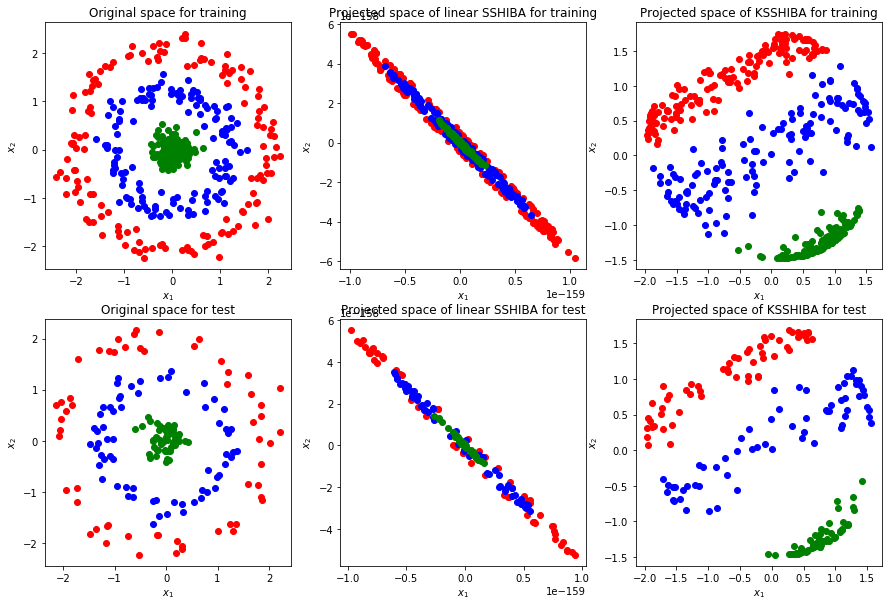

In [0]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.title("Original space for training")
plot_projected_data(X_tr, Y_tr)
plt.subplot(2,3,2)
plt.title("Projected space of linear SSHIBA for training")
plot_projected_data(myModel.q_dist.Z['mean'][:Y_tr.shape[0],:], Y_tr)
plt.subplot(2,3,3)
plt.title("Projected space of KSSHIBA for training")
#plot_projected_data(myKModel.q_dist.Z['mean'], Y_tr)
plot_projected_data(myKModel.q_dist.Z['mean'][:Y_tr.shape[0],:], Y_tr)

plt.subplot(2,3,4)
plt.title("Original space for test")
plot_projected_data(X_tst, Y_tst)
plt.subplot(2,3,5)
plt.title("Projected space of linear SSHIBA for test")
plot_projected_data(myModel.q_dist.Z['mean'][Y_tr.shape[0]:,:], Y_tst)
plt.subplot(2,3,6)
plt.title("Projected space of KSSHIBA for test")
#plot_projected_data(myKModel.Z_mean, Y_tst)
plot_projected_data(myKModel.q_dist.Z['mean'][Y_tr.shape[0]:,:], Y_tst)

plt.show()

We can also visually find the classification errors the model made with KSSHIBA

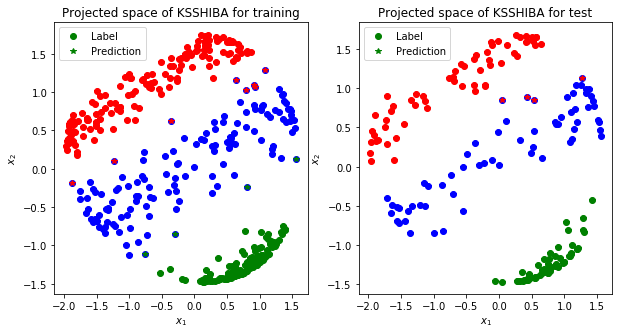

In [0]:
def plot_projected_data_pred(data, label, pred):
    
    """Plot the desired sample data assigning differenet colors according to their categories.
    Only two first dimensions of data ar plot and only three different categories are considered.

    Args:
        data: data set to be plot (number data x dimensions). 
        labes: target vector indicating the category of each data.
    """
    
    reds = label == 0
    blues = label == 1
    green = label == 2
    
    reds_p = pred == 0
    blues_p = pred == 1
    green_p = pred == 2

    plt.plot(data[reds, 0], data[reds, 1], "ro")
    plt.plot(data[blues, 0], data[blues, 1], "bo")
    plt.plot(data[green, 0], data[green, 1], "go", label = 'Label')
    plt.plot(data[reds_p, 0], data[reds_p, 1], "r*")
    plt.plot(data[blues_p, 0], data[blues_p, 1], "b*")
    plt.plot(data[green_p, 0], data[green_p, 1], "g*", label = 'Prediction')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Projected space of KSSHIBA for training")
Y_pred = np.argmax(myKModel.compute_predictions([None], [0], 1, tr = 1), axis=1)
plot_projected_data_pred(myKModel.q_dist.Z['mean'][:Y_tr.shape[0],:], Y_tr, Y_pred)
plt.subplot(1,2,2)
plt.title("Projected space of KSSHIBA for test")
Y_pred = np.argmax(myKModel.compute_predictions([None], [0], 1), axis=1)
plot_projected_data_pred(myKModel.q_dist.Z['mean'][Y_tr.shape[0]:,:], Y_tst, Y_pred)

In these images the points where the prediction label does not match with the real label are the errors.

#### Kernel reconstruction

Equivalently to the linear kernel, here we can compare the differences between the original kernel and the one the model learnt. We calculate the mean of the distribution of the input data, given by $\mu_{K^{(0)}} = Z  W^{(0)^T}$, where 0 corresponds to the input view, and compare it to the original kernel matrix, $K^{(0)}$.

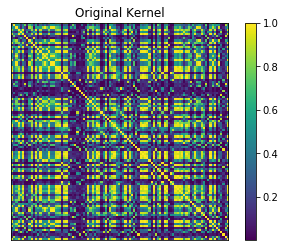

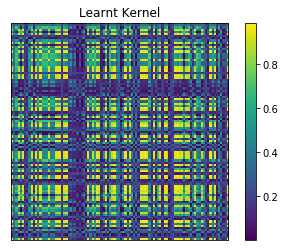

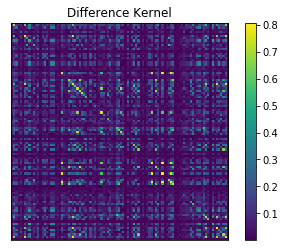

In [0]:
def plot_K(K, title):
    plt.figure()
    plt.imshow(abs(K))
    plt.colorbar()
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    plt.show()

N = 100
K = myKModel.X[0]['data'][:N,:N]
mean_K = (np.dot(myKModel.q_dist.Z['mean'], myKModel.q_dist.W[0]['mean'].T) + myKModel.q_dist.b[0]['mean'])[:N,:N]
diff_K = K - mean_K

plot_K(K, 'Original Kernel')
plot_K(mean_K, 'Learnt Kernel')
plot_K(diff_K, 'Difference Kernel')

## Feature Selection KSSHIBA

At this point we can visualize one of the adaptations done to KSSHIBA in order to carry out feature selection. This is done by including an ARD in the Kernel matrix to determine the relevance of each feature, $\lambda^{(m)}$. We decided to optimize the lower bound using pytorch to determine the value of the $\lambda^{(m)}$ parameters associated to the features which maximize the lower bound. 

### Synthetic data generation for feature selection

To check the viability of this version we are going to include some random features in the original matrix to check if the algorithm is capable of locating them.

In [0]:
# Inclusion of random features
DN0 = 300
X00  = np.hstack((X00,np.random.normal(0.0, 0.1, DN0 * N).reshape(N,DN0)))

from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X00, X1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)
X = np.vstack((X_tr, X_tst))

Let's now train the model specifying that we want to carry out feature selection with the input data.

In [0]:
myKc = 20            # number of latent features
prune = 1            # whether or not to prune the latent factors
sparse_fs = 1        # whether or not to carry out feature selection

# Training KSSHIBA, in the dual space
myKModel = ksshiba.SSHIBA(myKc, prune)   
Y1_tr = myKModel.struct_data(Y_tr, 'reg', 0)
Y1_tst = myKModel.struct_data(Y_tst, 'reg', 0)
K0 = myKModel.struct_data(X, 'reg', 0, V = X, kernel = 'rbf', sparse_fs = sparse_fs)

myKModel.fit(K0, Y1_tr, verbose = 1)
Y_pred = myKModel.compute_predictions(Y1_tst, X_tst = [None], m_in=[0], m_out=1, tr=0)
print('R2 KSSHIBA: %.3f' %(r2_score(Y_tst, Y_pred, multioutput = 'uniform_average')))

Working on the dual space.
Iteration 150 Lower Bound 154149.2 K   16
Model correctly trained. Convergence achieved
R2 KSSHIBA: 0.356


We can now visualize the values of $\lambda^{(m)}$ learnt by the model, which provide information of the relevance of every single input feature.

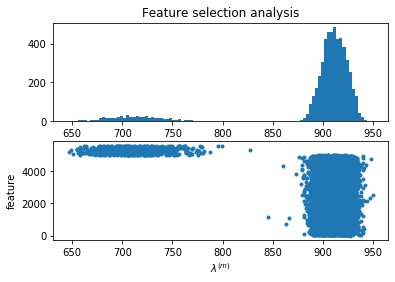

In [0]:
lamb, _ = myKModel.sparse_K.get_params()

ax1 = plt.subplot(2, 1, 1)
plt.title('Feature selection analysis')
plt.hist(lamb, 100)
ax2 = plt.subplot(2, 1, 2)
plt.plot(lamb, np.arange(len(lamb)),'.')
plt.xlabel(r'$\lambda^{(m)}$ ')
plt.ylabel('feature')
plt.show()

This figure shows how the more relevant features, the first 5000, have a greater value of $\lambda^{(m)}$ than the last 300, which correspond to the noise we have added.

### LFW Dataset

We can now check the feature selection capabilities of the algorithm on an exemplary database. The LFW database is a publicly available database which is composed by face images of celebrities. In particular we are going to use only the images of the people with more than 10 samples.

In [0]:
import pickle
        
my_dict = pickle.load( open('Databases/data_lfwa_0.4_7classes.pkl', "rb" ), encoding='latin1' )

X = my_dict['X'].astype(float)
Y_lbl = (my_dict['Y_lbl']).astype(int)
Y_lbl = Y_lbl[:,np.sum(Y_lbl, axis = 0) > 10]
Y_cat = (my_dict['Y_cat']).astype(int)
h = my_dict['h']
w = my_dict['w']
target_names = my_dict['target']

    
idx = np.arange(X.shape[0],)
from sklearn.model_selection import train_test_split
idx_tr, idx_tst = train_test_split(idx, test_size=0.3, random_state = 31)
X_tr = X[idx_tr,:]
X_tst = X[idx_tst,:]
Y_tr = Y_cat[idx_tr, np.newaxis].astype(int)
Y_tst = Y_cat[idx_tst, np.newaxis].astype(int)
Y_lbl_tr = Y_lbl[idx_tr,:].astype(int)
Y_lbl_tst = Y_lbl[idx_tst,:].astype(int)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)
X = np.vstack((X_tr, X_tst))
Y = np.vstack((Y_tr, Y_tst))

In [0]:
myKc = 100            # number of latent features
prune = 1             # whether to prune the irrelevant latent features
sparse_fs = 1         # whether or not to carry out feature selection

# Training KSSHIBA, in the dual space
myKModel = ksshiba.SSHIBA(myKc, prune)   
Y1 = myKModel.struct_data(Y, 'cat', 0)
Y2_tr = myKModel.struct_data(Y_lbl_tr, 'mult', 0)
Y2_tst = myKModel.struct_data(Y_lbl_tst, 'mult', 0) 
K0 = myKModel.struct_data(X, 'reg', 0, V = X, kernel = 'rbf', sparse_fs = sparse_fs)

myKModel.fit(K0, Y1, Y2_tr, pruning_crit = 1e-2, max_iter = 10, Y_tst = Y2_tst, AUC = 1, verbose = 1)
print('AUC KSSHIBA: %.3f' %(myKModel.AUC[-1]))

Working on the dual space.
Iteration 10 Lower Bound 12298517.4 K   98

AUC KSSHIBA: 0.660


### Visualization of the results

Thanks to the nature of the data, we can now visualize the relevance of each feature, meaning the relevance of each pixel. In particular, we get that the lighter pixels represent the more relevant pixels, while the darker represent the less relevant.

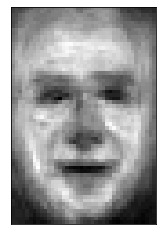

In [0]:
lamb, _ = myKModel.sparse_K.get_params()

import matplotlib.pyplot as plt
h,w = 60,40
plt.figure()
plt.imshow(lamb.reshape((h, w)), cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())
plt.show()